In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [2]:
df = pd.read_csv('C:/Users/norri/Desktop/amazon_full.csv', parse_dates=['week'])
df = df[df['client_name'] == 'KIND']
df = df.drop_duplicates(subset=['sales', 'week'])
df['week'] = df['week'] = pd.to_datetime(df['week'])
df = df.sort_values(by=['week'])
df['sales'] = df['sales'].values
df['index'] = df['week']
df.set_index('index', inplace=True)
df = df[['week','sales']]

In [3]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

Explain the plot above and below

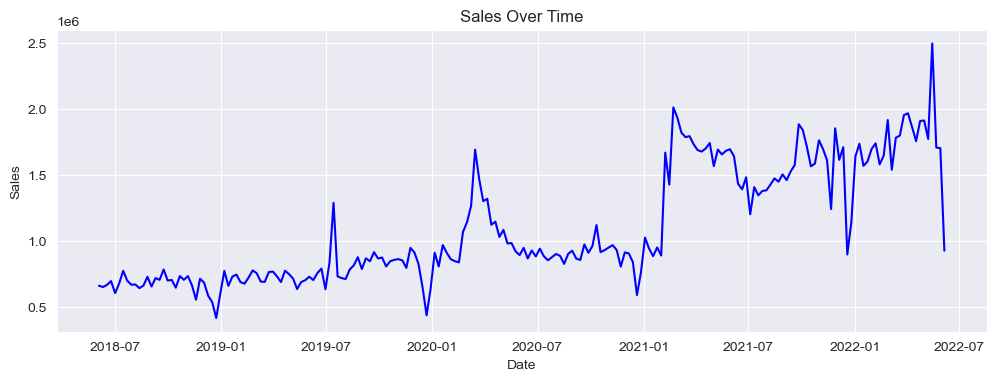

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(12, 4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, df['week'], df['sales'], title='Sales Over Time')

Both plots appear to demonstrate a slight degree of annual cycles

Value = Base Level + Trend + Seasonality + Error - Additive Decomposition
Value = Base Level x Trend x Seasonality x Error - Multiplicative Decompisition

The Augmented Dickey-Fuller Test checks for the important
condition of stationarity. Falling below the alpha value
means we must correct for it later

In [5]:
adf_test = ADFTest(alpha = .05)
adf_test.should_diff(df['sales'])

(0.03544219371758431, False)

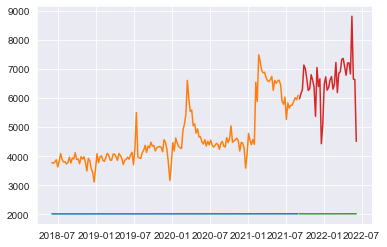

In [6]:
train = df[:170]
test = df[-40:]
plt.plot(train)
plt.plot(test)

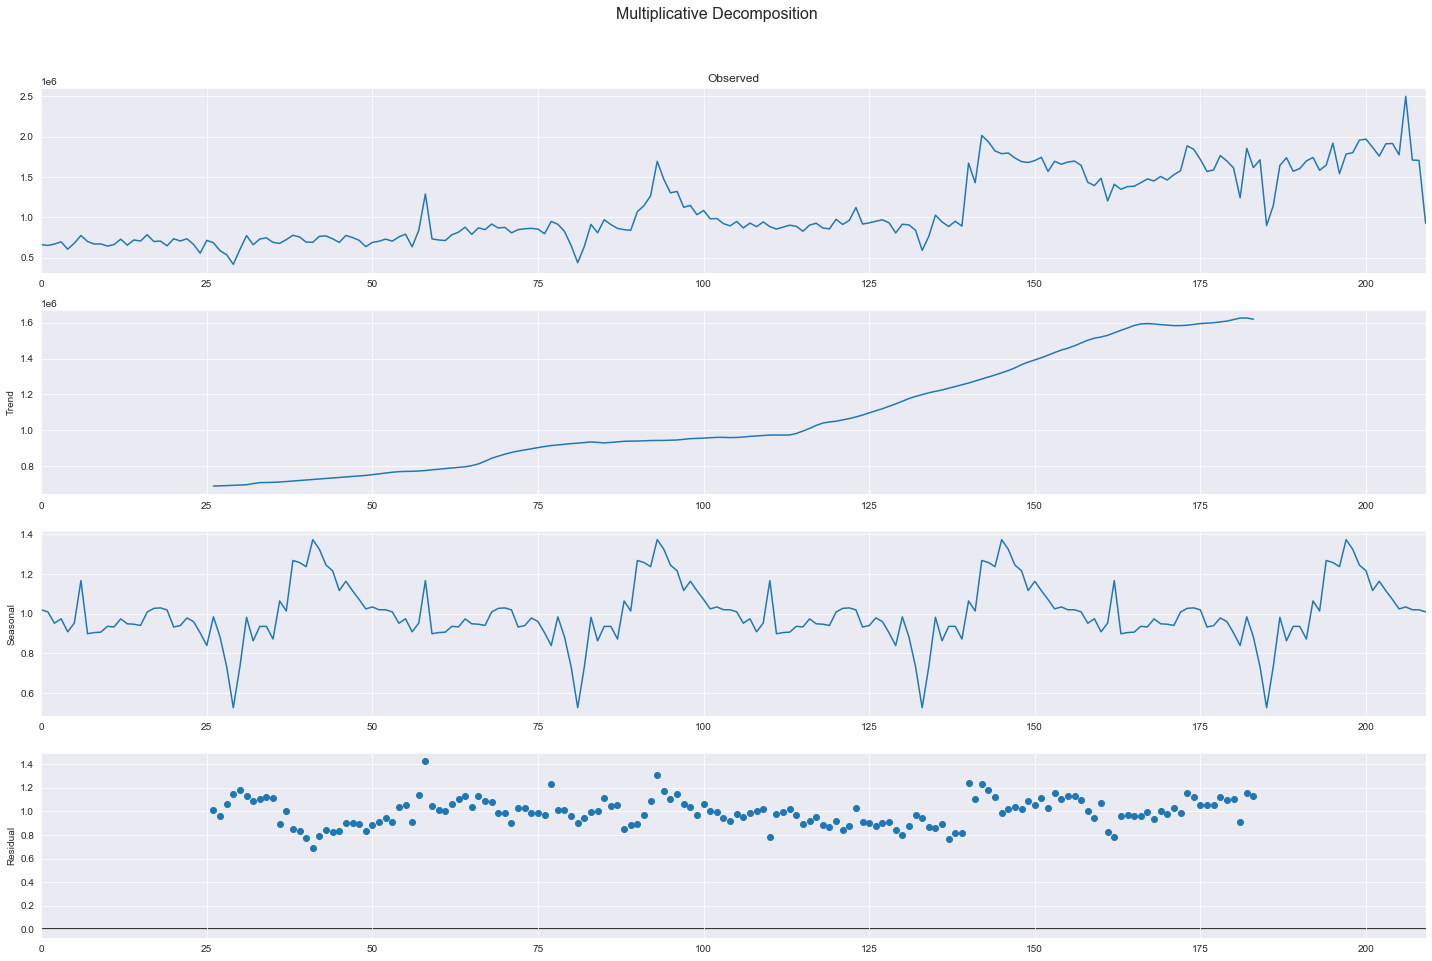

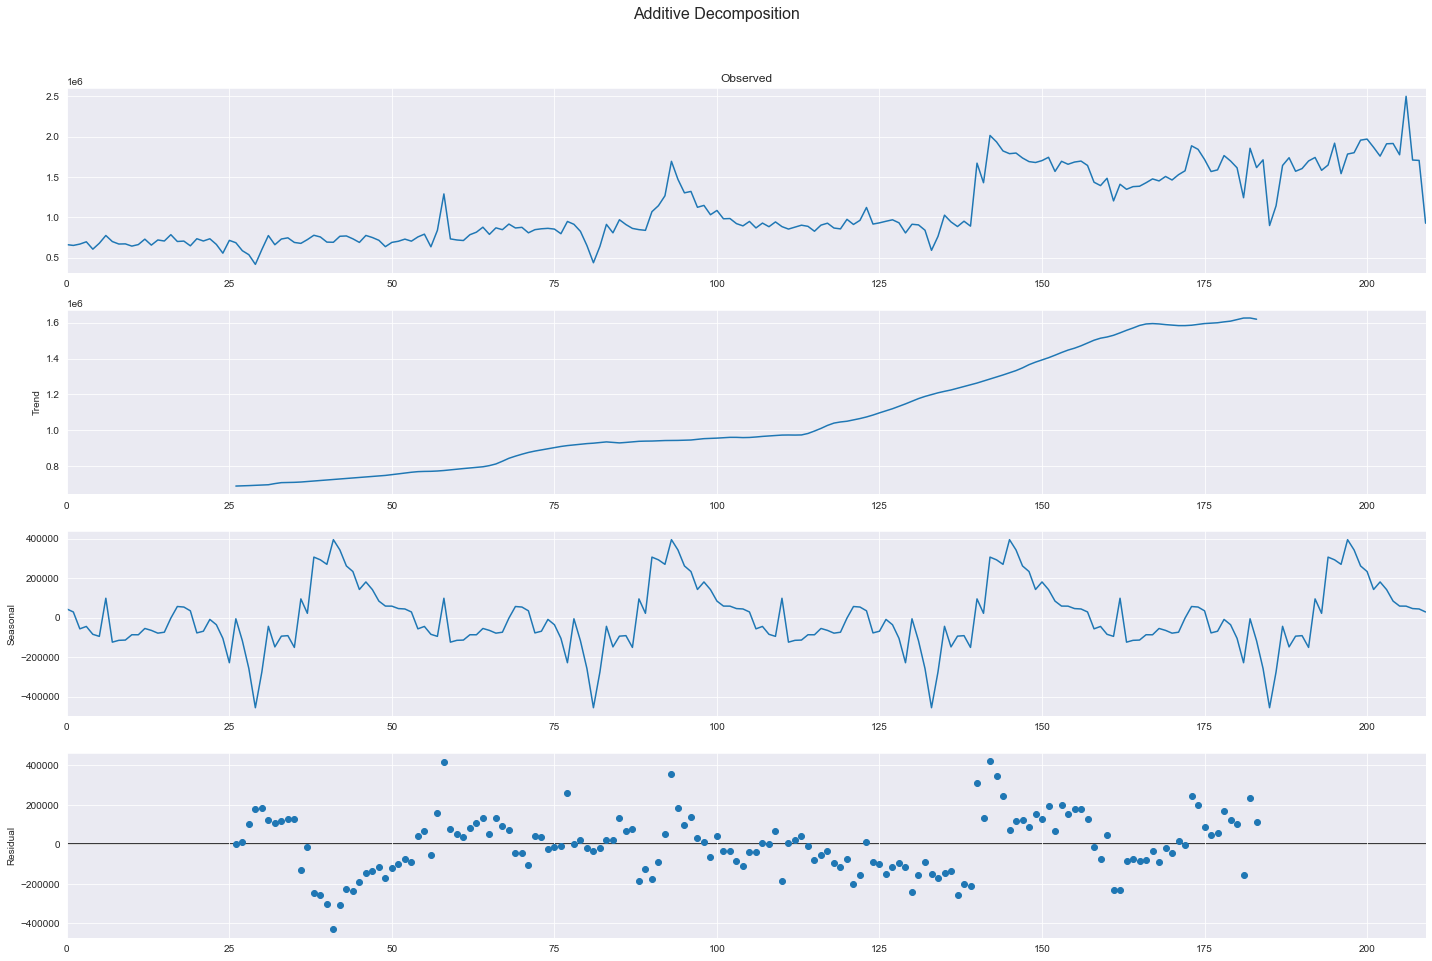

In [7]:
multiplicative_decomposition = seasonal_decompose(df['sales'].values,
                                                  model='multiplicative',
                                                  period=52)
additive_decomposition = seasonal_decompose(df['sales'].values, model='additive',
                                            period=52)
plt.rcParams.update({'figure.figsize': (20,14)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Variance of Residuals appear to be random and similar between additive and multiplicative

Explain interpretation of plots above and below

Text(0.5, 1.0, 'Sales Detrended')

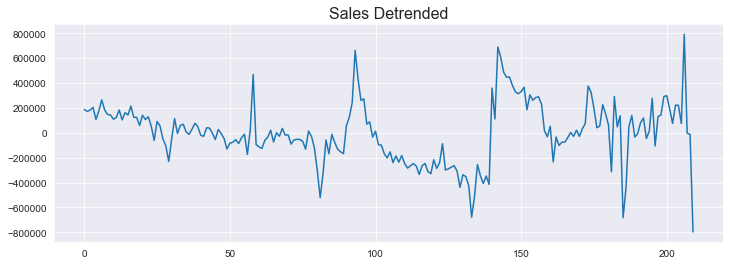

In [8]:
detrended = signal.detrend(df['sales'].values)
plt.rcParams.update({'figure.figsize': (12,4)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

[]

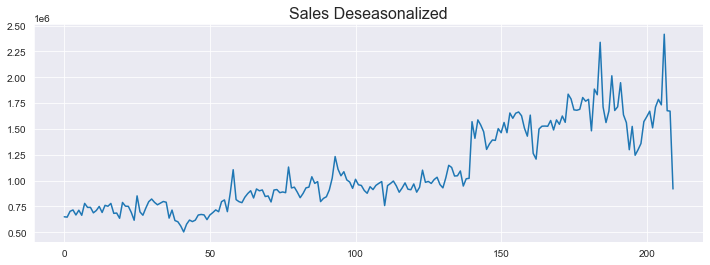

In [9]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=52)
deseasonalized = df['sales'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Sales Deseasonalized', fontsize=16)
plt.plot()

Elaborate on multiplicative, etc

Detrending and deasonalization show both a nonconstant variance and seasonality

Text(0.5, 1.0, 'Sales Detrended')

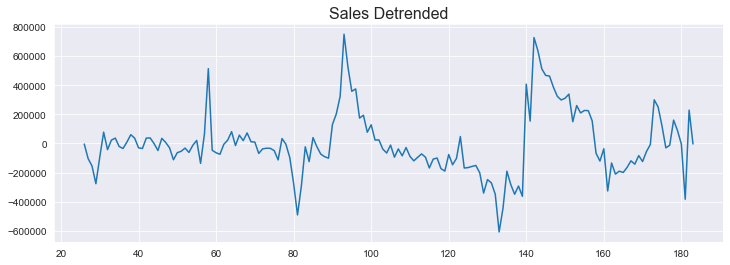

In [10]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=52)
detrended = df['sales'].values - result_mul.trend
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

Explain detrending

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

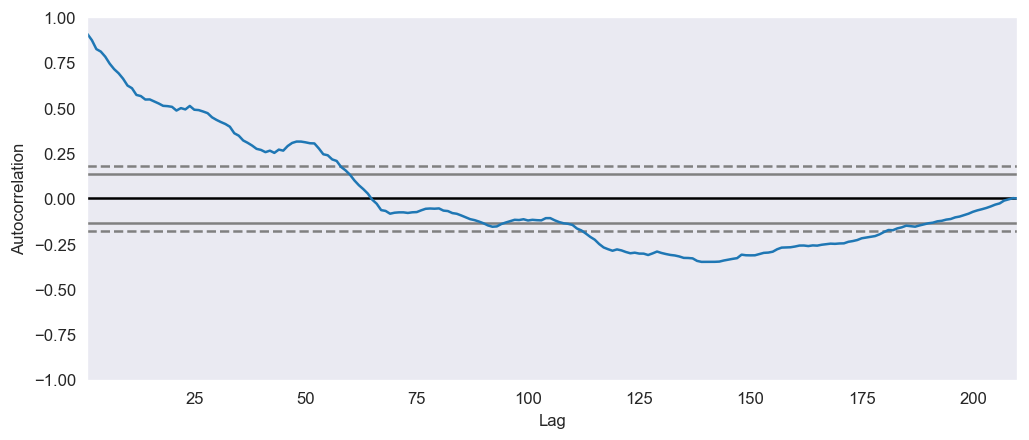

In [11]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

Discuss autorcorrelatiomn

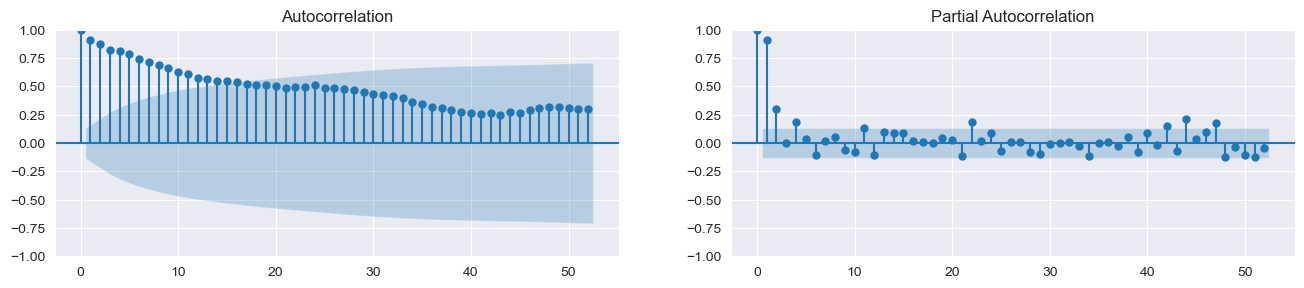

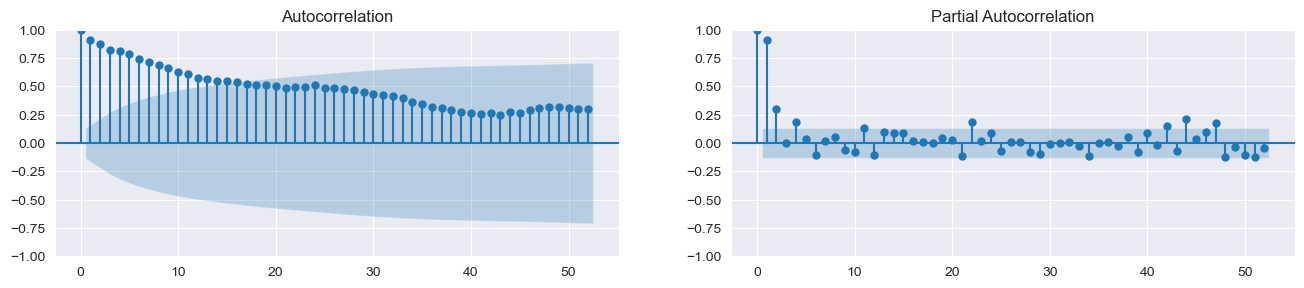

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(df['sales'].tolist(), lags=52, ax=axes[0])
plot_pacf(df['sales'].tolist(), lags=52, ax=axes[1])

Discuss meaning of all four plots

Similar annual seasonality trends appear with peaks and valleys
on weekly basis

Point out what lag is and what it means for the model and what acceotable autolag
numbers are

In [13]:
ac1 = df['sales'].autocorr(lag=1)
print("One week Lag: ", ac1)
ac2 = df['sales'].autocorr(lag=2)
print("Two week Lag: ", ac2)
ac3 = df['sales'].autocorr(lag=3)
print("Three week Lag: ", ac3)
ac4 = df['sales'].autocorr(lag=4)
print("Four Week Lag: ", ac4)
ac5 = df['sales'].autocorr(lag=5)
print("Five Week Lag: ", ac5)
ac6 = df['sales'].autocorr(lag=6)
print("Six Week Lag: ", ac6)
ac7 = df['sales'].autocorr(lag=7)
print("Seven Week Lag: ", ac7)
ac8 = df['sales'].autocorr(lag=8)
print("Eight Week Lag: ", ac8)
ac9 = df['sales'].autocorr(lag=9)
print("Nine Week Lag: ", ac9)
ac10 = df['sales'].autocorr(lag=10)
print("Ten Week Lag: ", ac10)
ac11 = df['sales'].autocorr(lag=11)
print("Eleven Week Lag: ", ac11)
ac12 = df['sales'].autocorr(lag=12)
print("Twelve Week Lag: ", ac12)

One week Lag:  0.9098153102364003
Two week Lag:  0.8821806039294661
Three week Lag:  0.8389246955797052
Four Week Lag:  0.8490497092696655
Five Week Lag:  0.8279749295809783
Six Week Lag:  0.7972397702030303
Seven Week Lag:  0.7741044310663454
Eight Week Lag:  0.7569161243131861
Nine Week Lag:  0.7337078457624796
Ten Week Lag:  0.7031688420379568
Eleven Week Lag:  0.6983477370843819
Twelve Week Lag:  0.6648409440726896


Demonstration of small autocorrelation with lag

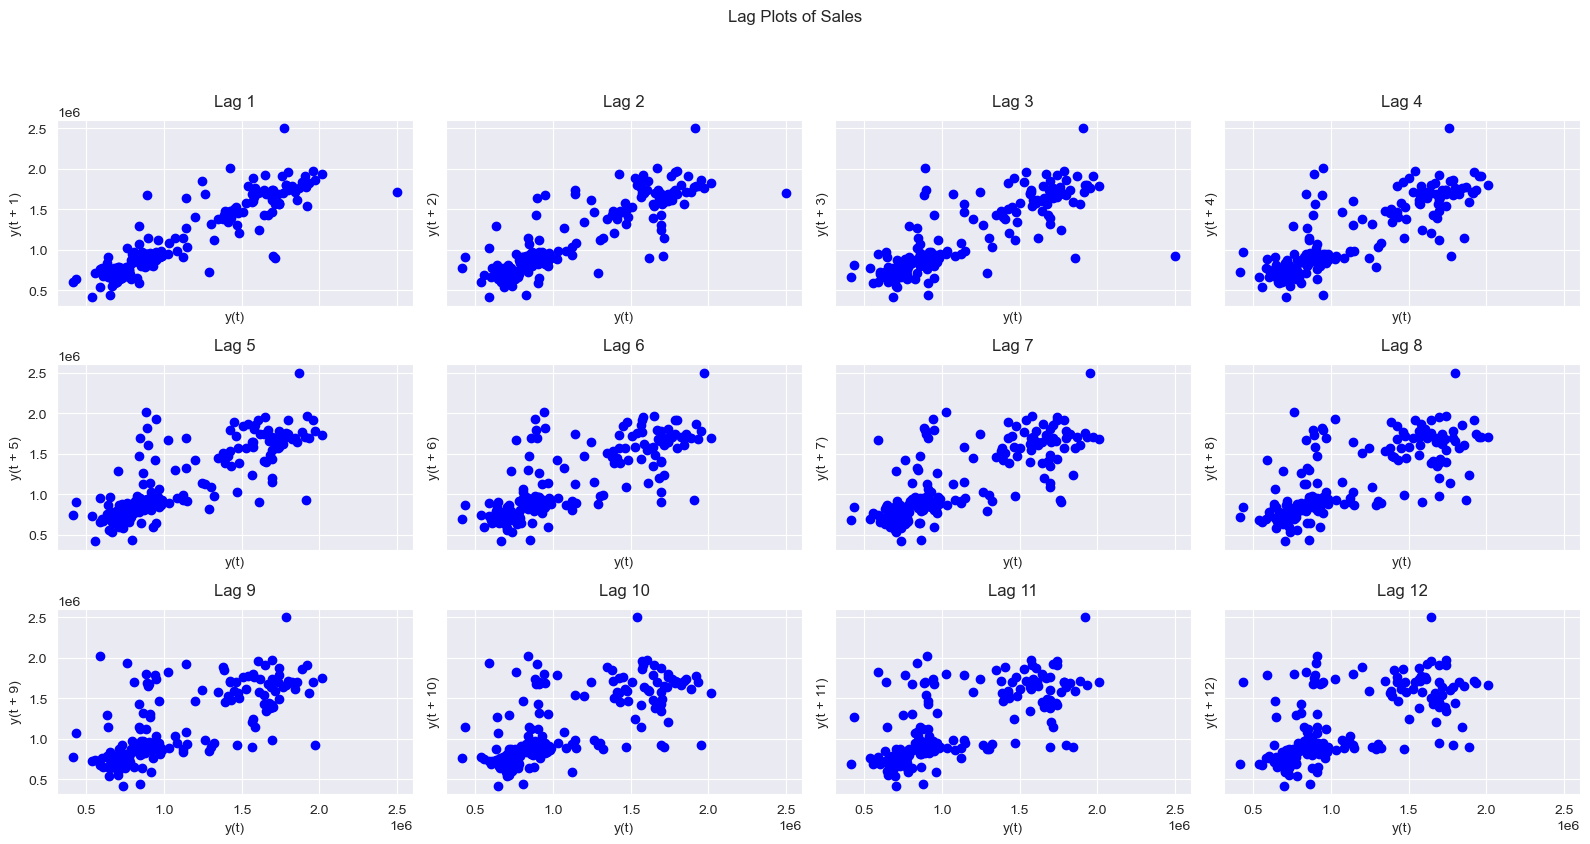

In [14]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:12]):
    lag_plot(df['sales'], lag=i+1, ax=ax, c='blue')
    ax.set_title('Lag ' + str(i+1))
fig.suptitle('Lag Plots of Sales', y=1.05)
fig.tight_layout()
plt.show()

Decreasing linear trend between lag plots demonstrates similar results to
lag scores, suggesting some positive autocorrelation between first week

In [15]:
train = df['sales'][:105]
test = df['sales'][105:]
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2735.958, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2735.427, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2734.359, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2733.997, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2731.299, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2733.092, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2733.220, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2732.727, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2733.998, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2730.136, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2732.487, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2733.508, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2731.985, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

SARIMAX MODEL

C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


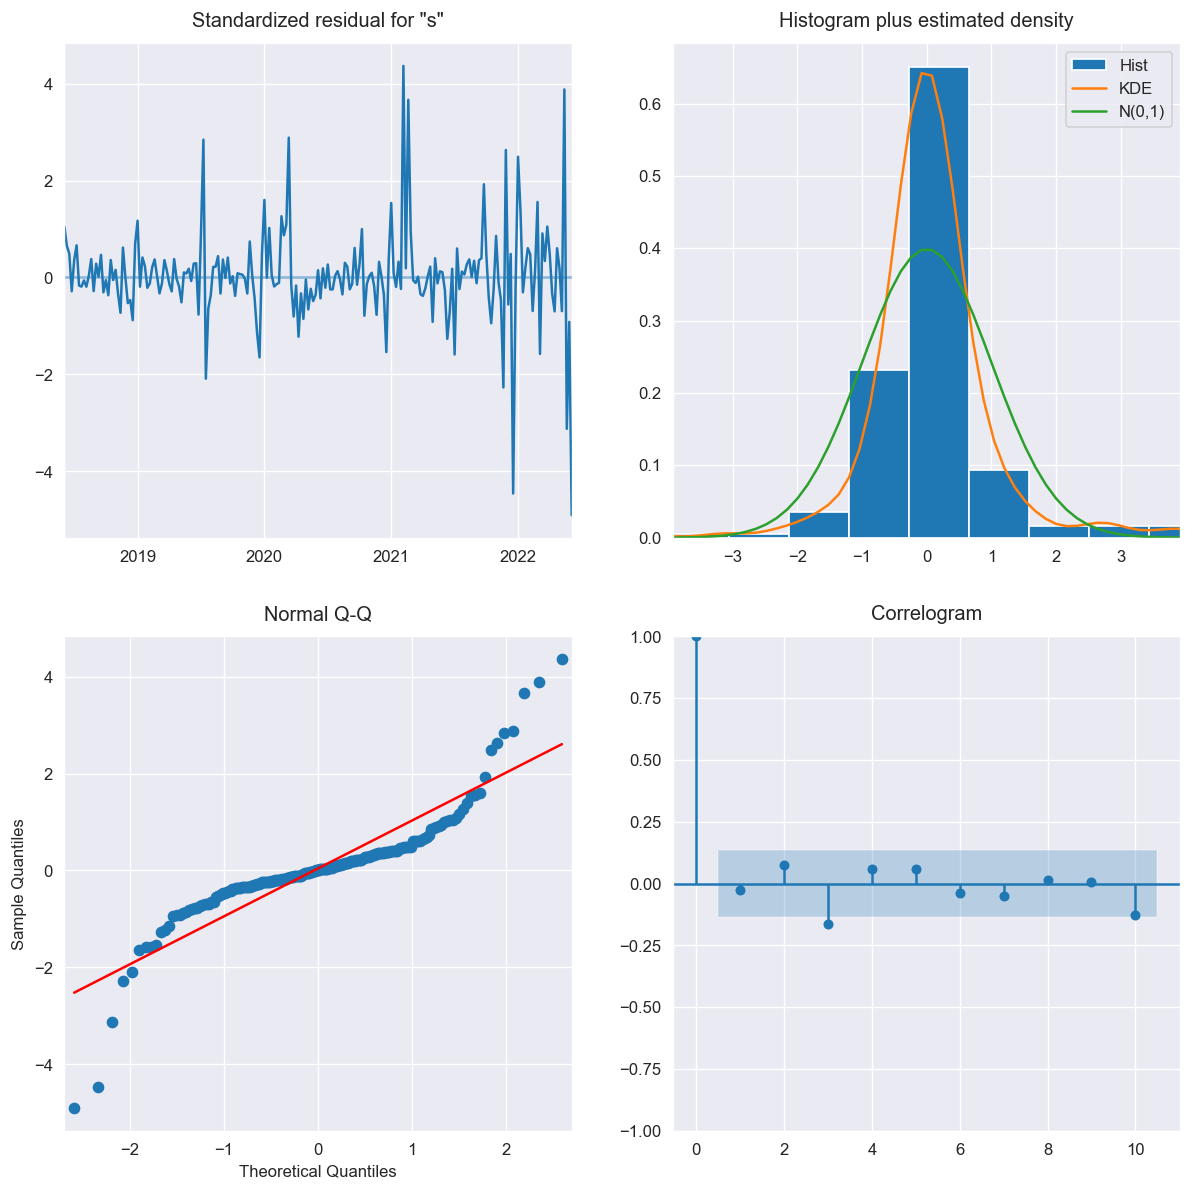

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  210
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2818.702
Date:                Sun, 17 Jul 2022   AIC                           5643.405
Time:                        02:42:00   BIC                           5653.432
Sample:                    06-03-2018   HQIC                          5647.459
                         - 06-05-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1741      0.144      1.209      0.227      -0.108       0.456
ma.L1         -0.5354      0.123     -4.343      0.000      -0.777      -0.294
sigma2      3.096e+10   6.77e-12   4.57e+21      0.000     3.1e+10     3.1e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               555.08
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               6.06   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+37. Standard errors may be unstable.
"""

In [16]:
mod = sm.tsa.statespace.SARIMAX(df['sales'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=True,
                                freq='W')
results = mod.fit()
results.plot_diagnostics(figsize=(12, 12))
plt.show()
results.summary()

SARIMAX Diagnostic Statistics

In [17]:
forecast = forecast.squeeze()
forecast_accuracy(forecast, test)

{'mape': 0.29323940575799573,
 'me': -391765.99684205826,
 'mae': 461968.99016074504,
 'mpe': -0.20872279397894572,
 'rmse': 560440.7134131071,
 'corr': 0.2833033648409795,
 'minmax': 0.2860653949666093}

In [18]:
df_small = df[['week', 'sales']]

In [19]:
result = adfuller(df_small.sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.760572
p-value: 0.400205


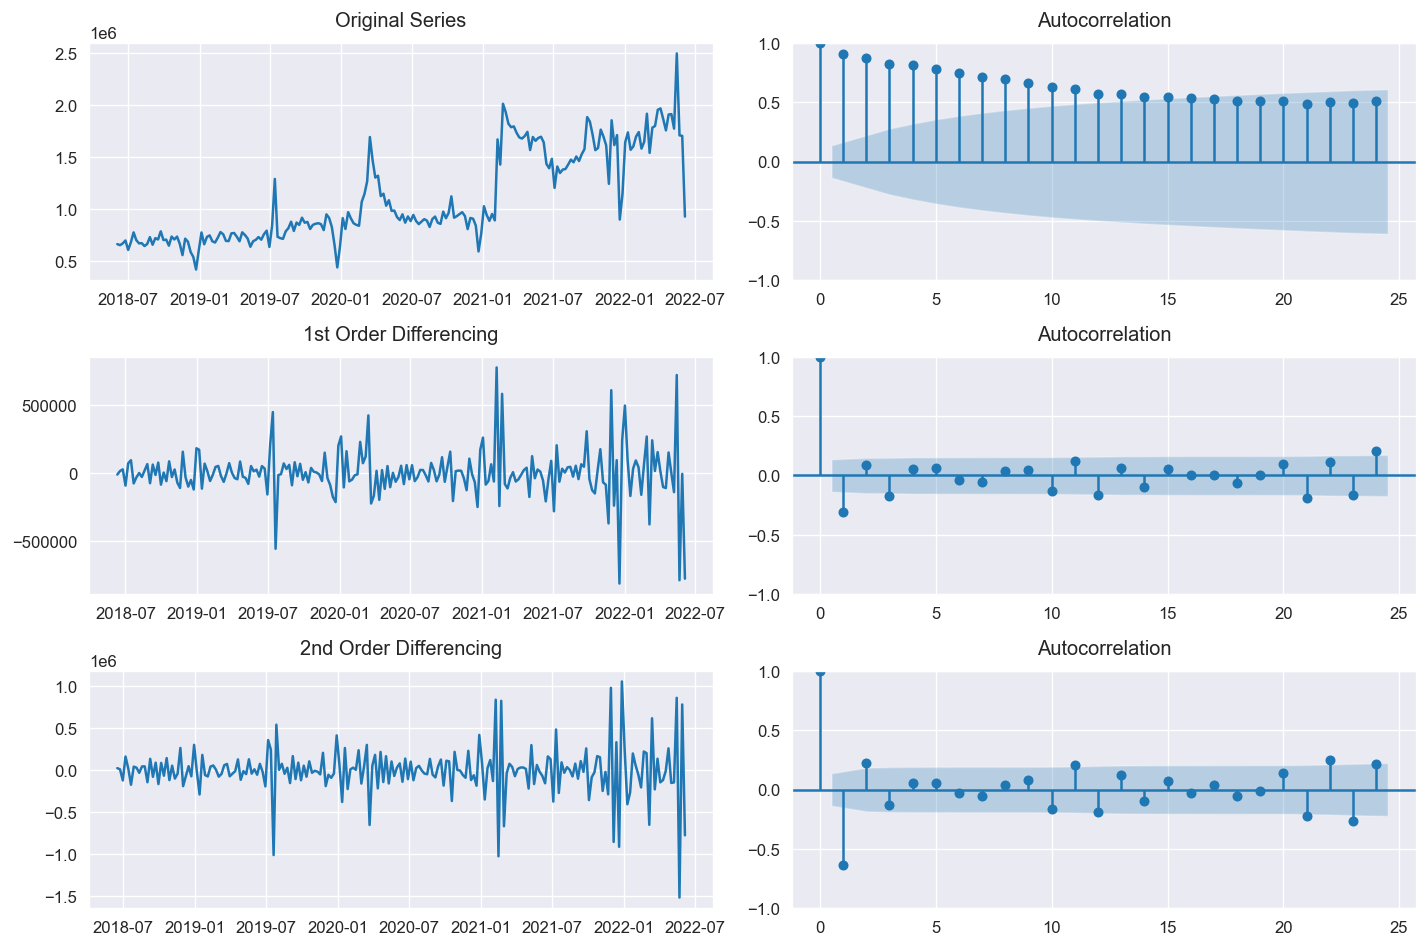

In [20]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_small.sales); axes[0, 0].set_title('Original Series')
plot_acf(df_small.sales, ax=axes[0, 1])

axes[1, 0].plot(df_small.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_small.sales.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(df_small.sales.diff().diff()); axes[2, 0].set_title('2nd Order '
                                                                  'Differencing')
plot_acf(df_small.sales.diff().diff().dropna(), ax=axes[2, 1])
fig.tight_layout()
plt.show()

In [21]:
# Fix Training and Test Data for Remaining Functions
df_small = df_small.sort_values(by=['week'])
df_model = df_small.set_index('week')
df_small = df_small.reset_index()
df_small = df_small[['week', 'sales']]
train = df_small['sales'][:105]
test = df_small['sales'][105:]
train_model = df_model['sales'][:105]
test_model = df_model['sales'][105:]

In [22]:
train = df_model['sales']
arima_model = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,
                         max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5493.345, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5392.848, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5387.578, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5471.018, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5382.086, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5394.899, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5383.627, Time=0.46 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5383.099, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5383.368, Time=0.27 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5390.015, Time=0.22 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=5385.047, Time=0.75 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=5362.245, Time=0.14 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5392.904, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5383.421, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  210
Model:             SARIMAX(0, 1, 0)x(4, 1, [1], 12)   Log Likelihood               -2673.047
Date:                              Sun, 17 Jul 2022   AIC                           5358.094
Time:                                      02:42:41   BIC                           5377.793
Sample:                                           0   HQIC                          5366.068
                                              - 210                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3743      0.285     -1.312      0.190      -0.934       0.185
ar.S.L24       0.0203      0.291      0.070      0.944      -0.551       0.591
ar.S.L36      -0.1864      0.188     -0.991      0.321      -0.555       0.182
ar.S.L48      -0.0827      0.155     -0.533      0.594      -0.387       0.221
ma.S.L12      -0.7133      0.290     -2.457      0.014      -1.282      -0.144
sigma2       3.94e+10   1.55e-11   2.54e+21      0.000    3.94e+10    3.94e+10
===================================================================================
Ljung-Box (L1) (Q):                  13.79   Jarque-Bera (JB):               164.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+37. Standard errors may be unstable.
"""

In [23]:
train = df_model['sales'][:160]
test = df_model['sales'][-50:]
prediction = pd.DataFrame(arima_model.predict(n_periods=50), index=test.index)
shift = test.iloc[0] - prediction.iloc[0,0]
prediction = prediction + shift

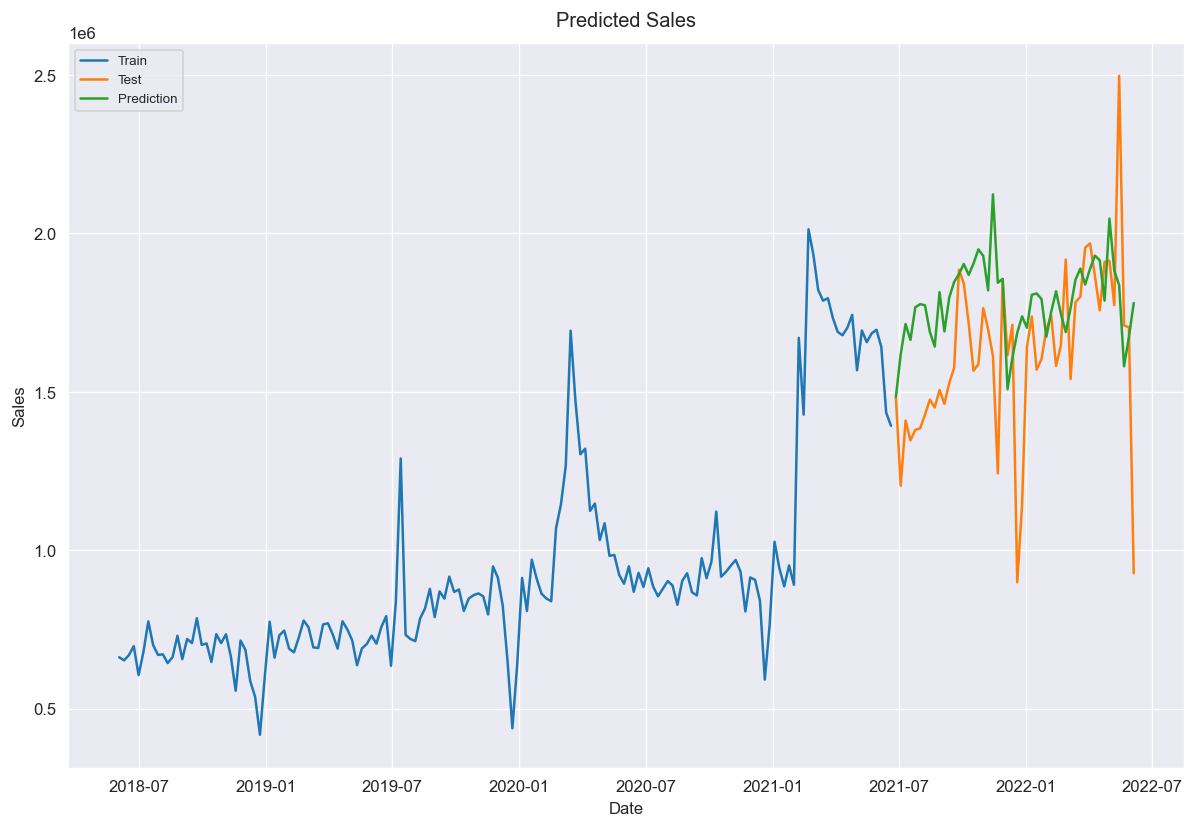

In [24]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prediction, label='Prediction')
plt.title('Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Arima Model Statistics

In [25]:
prediction = prediction.squeeze()
forecast_accuracy(prediction, test)

{'mape': 0.1657741860210311,
 'me': 166761.96633706984,
 'mae': 231498.84751885594,
 'mpe': 0.1341403516120683,
 'rmse': 305382.97278693045,
 'corr': 0.3382478596669309,
 'minmax': 0.12682113757619196}